<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Observations" data-toc-modified-id="Observations-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Observations</a></span></li><li><span><a href="#Traits" data-toc-modified-id="Traits-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Traits</a></span></li><li><span><a href="#SDM-predictions" data-toc-modified-id="SDM-predictions-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>SDM predictions</a></span></li><li><span><a href="#Community-level-indices" data-toc-modified-id="Community-level-indices-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Community-level indices</a></span></li></ul></li><li><span><a href="#Spatial-distribution" data-toc-modified-id="Spatial-distribution-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Spatial distribution</a></span></li></ul></li><li><span><a href="#Initial-evaluation" data-toc-modified-id="Initial-evaluation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial evaluation</a></span><ul class="toc-item"><li><span><a href="#PFAL" data-toc-modified-id="PFAL-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>PFAL</a></span></li><li><span><a href="#SDM" data-toc-modified-id="SDM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SDM</a></span></li><li><span><a href="#MEM---unscaled" data-toc-modified-id="MEM---unscaled-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>MEM - unscaled</a></span></li><li><span><a href="#MEM---scaled" data-toc-modified-id="MEM---scaled-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>MEM - scaled</a></span></li></ul></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Synthesis" data-toc-modified-id="Synthesis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Synthesis</a></span></li><li><span><a href="#Sensitivity-analysis" data-toc-modified-id="Sensitivity-analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sensitivity analysis</a></span></li></ul></li></ul></div>

# CAMELIA IMPLEMENTATION

In [1]:
%load_ext autoreload
%autoreload 2

## Preparation

### Dependencies

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew, kurtosis
from utilities.data_utilities import *
from utilities.evaluation import *
from utilities.viz_utilities import *
from utilities.neural_model import *
from utilities.interpretability import *

### Dataset

#### Observations

In [9]:
Y = pd.read_csv('data/survey_obs.csv', index_col=0)

In [10]:
splist = Y.columns.tolist()
sites = Y.index.tolist()
nsite = len(sites)
nspecies = len(splist)

<Axes: >

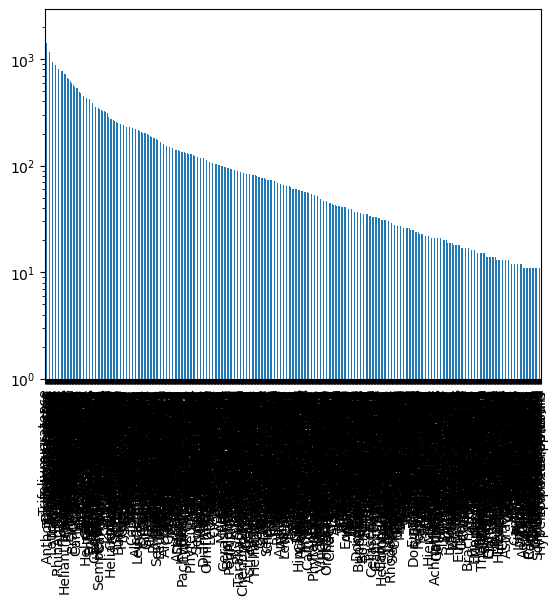

In [11]:
Y.sum().sort_values(ascending=False).plot.bar(log=True)

Text(0.5, 1.0, 'Imbalance ratios')

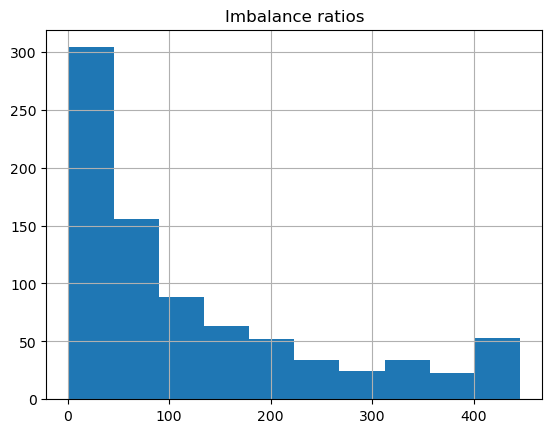

In [12]:
npos = Y.sum()
nneg = nsite - npos
imb_ratio = nneg / npos

imb_ratio.hist()
plt.title('Imbalance ratios')

#### Traits

In [14]:
T_raw = pd.read_csv('data/traits.csv',index_col=0)

In [15]:
tlist = T_raw.columns.tolist()
ntrait = len(tlist)

In [16]:
imputer = KNNImputer(n_neighbors=10)
imputer.fit(T_raw)

T = pd.DataFrame(data=imputer.transform(T_raw.loc[splist,tlist]),columns=tlist, index=splist)

array([[<Axes: title={'center': 'LNC'}>, <Axes: title={'center': 'SLA'}>],
       [<Axes: title={'center': 'PLH'}>, <Axes: >]], dtype=object)

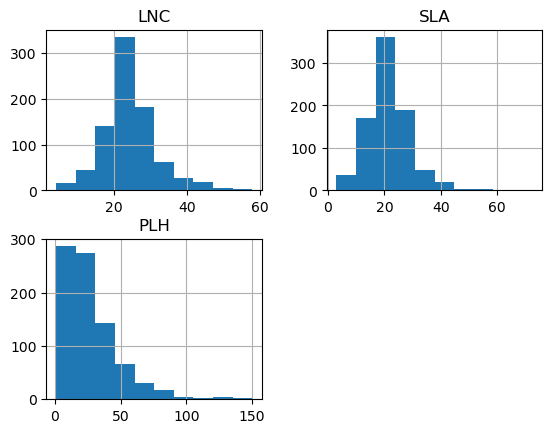

In [17]:
T.hist()

### Cross validation folds

In [19]:
metadata = pd.read_csv('data/metadata.csv', index_col=0)

<Axes: xlabel='lon', ylabel='lat'>

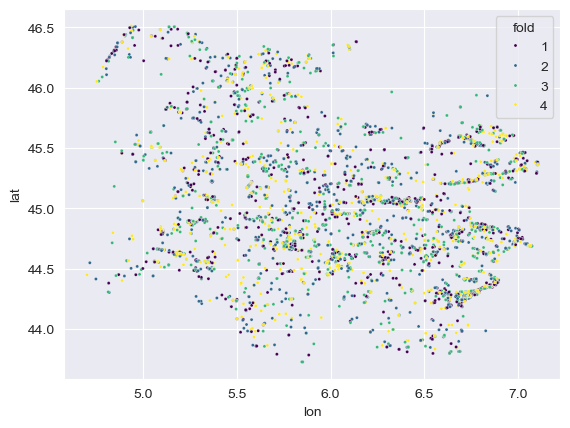

In [30]:
sns.set_style("darkgrid")
sns.scatterplot(data=metadata, x='lon', y='lat', hue='fold', palette='viridis',s=5.0)

#### SDM predictions

In [33]:
P_inter = pd.read_csv('data/ssdm_predictions.csv', index_col=0)

In [35]:
### binarisation by species-specific TSS-optimized threshold 
for fold in range(1,5):
    test_idx = metadata[metadata['fold'] == fold].index
    train_idx = metadata[metadata['fold'] != fold].index
    
    ### Species output
    Y_train = Y.loc[train_idx]
    Y_test = Y.loc[test_idx] 
    
    ### Species input
    P_train = P_inter.loc[train_idx]
    P_test = P_inter.loc[test_idx]

    prediction_raw = pd.DataFrame((P_test)*1)
    prediction_raw.to_csv('results/sdm_raw_%s.csv' %(fold))
    
    th_list = optimize_thres(Y_train,P_train)
    prediction_opth = pd.DataFrame((P_test>th_list)*1)
    prediction_opth.to_csv('results/sdm_bin_opth_%s.csv' %(fold))
        

#### Community-level indices

In [41]:
Y_rich, T_mean, T_std, T_skew, T_kurt = compute_functional_indices(Y,T)

In [42]:
Y_MEM_rich_inter = pd.read_csv('data/community_indices/SR_mem.csv',index_col=0)
Y_MEM_rich_inter['fold']=metadata['fold']
Y_MEM_rich = pd.concat([Y_MEM_rich_inter],axis=0)

In [43]:
Y_MEM_CM_inter = pd.read_csv('data/community_indices/CM_mem.csv',index_col=0)
Y_MEM_CM_inter['fold']=metadata['fold']
Y_MEM_CM = pd.concat([Y_MEM_CM_inter],axis=0)

In [44]:
Y_MEM_CSTD_inter = pd.read_csv('data/community_indices/CSTD_mem.csv',index_col=0)
Y_MEM_CSTD_inter['fold']=metadata['fold']
Y_MEM_CSTD = pd.concat([Y_MEM_CSTD_inter],axis=0)

In [47]:
Y_PROXY_rich_inter = pd.read_csv('data/community_indices/SR_proxy.csv',index_col=0)
Y_PROXY_rich_inter['fold']=metadata['fold']
Y_PROXY_rich = pd.concat([Y_PROXY_rich_inter],axis=0)

In [49]:
Y_PROXY_CM_inter = pd.read_csv('data/community_indices/CM_proxy.csv',index_col=0)
Y_PROXY_CM_inter['fold']=metadata['fold']
Y_PROXY_CM = pd.concat([Y_PROXY_CM_inter],axis=0)

In [51]:
Y_PROXY_CSTD_inter = pd.read_csv('data/community_indices/CSTD_proxy.csv',index_col=0)
Y_PROXY_CSTD_inter['fold']=metadata['fold']
Y_PROXY_CSTD = pd.concat([Y_PROXY_CSTD_inter],axis=0)

## Initial evaluation

### Community indices from SSDM

In [87]:
comm_perfs = []
jaccard_perfs=[]
eps=1e-6
for fold in range(1,5):
    P_train, Y_train, P_test, Y_test = get_species_data(metadata,Y, P=P_inter, fold=fold)
    
    ### Raw probability:
    test_comm_perfs= evaluate_pfal(P_train, P_test, Y_train, Y_test, splist, tlist, T, method='raw', do_residual=False, eps=1e-6)
    test_comm_perfs['index'] = test_comm_perfs.index
    test_comm_perfs['fold']=fold
    test_comm_perfs['subset']='test'
    test_comm_perfs['jaccard']=["", "", "", "", "", "", "","",""]
    test_comm_perfs['postprocess']='raw'
    test_comm_perfs['trait']=["", "LNC", "SLA", "PLH", "LNC", "SLA", "PLH","",""]
    test_comm_perfs['indice']=["", "cm", "cm", "cm", "cstd", "cstd", "cstd","",""]
    test_comm_perfs['archi']='sdm'
    test_comm_perfs['species_loss'] = 'sdm'
    test_comm_perfs['func_loss']='sdm'
    test_comm_perfs = test_comm_perfs[['index','r2','mse','pearson','pearson_pv','spearman','spearman_pv','jaccard','postprocess','trait', 'indice', 'fold','subset','archi','species_loss','func_loss']]
    comm_perfs.append(test_comm_perfs)
    del test_comm_perfs
    
    ### With optimized thresholds
    test_comm_perfs= evaluate_pfal(P_train, P_test, Y_train, Y_test, splist, tlist, T, method='opth', do_residual=False, eps=1e-6)
    test_comm_perfs['index'] = test_comm_perfs.index
    test_comm_perfs['fold']=fold
    test_comm_perfs['subset']='test'
    test_comm_perfs['postprocess']='opth'
    test_comm_perfs['trait']=["", "LNC", "SLA", "PLH", "LNC", "SLA", "PLH","",""]
    test_comm_perfs['indice']=["", "cm", "cm", "cm", "cstd", "cstd", "cstd","",""]
    test_comm_perfs['archi']='sdm'
    test_comm_perfs['species_loss'] = 'sdm'
    test_comm_perfs['func_loss']='sdm'
    test_comm_perfs = test_comm_perfs[['index','r2','mse','pearson','pearson_pv','spearman','spearman_pv','jaccard','postprocess','trait', 'indice', 'fold','subset','archi','species_loss','func_loss']]
    comm_perfs.append(test_comm_perfs)
    del test_comm_perfs  
init_comm_perfs = pd.concat(comm_perfs,axis=0,ignore_index=True)
init_comm_perfs.to_csv('results/init_comm_perfs.csv')

Using interpolation fold 1


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

Using interpolation fold 2


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

Using interpolation fold 3


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use 

Using interpolation fold 4


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


### Species predictions SSDM

In [101]:
all_perfs = []
eps=1e-6
for fold in range(1,5):
    P_train, Y_train, P_test, Y_test = get_species_data(metadata,Y,P= P_inter, fold=fold)
    ### With optimized thresholds
    th_list = optimize_thres(Y_train, P_train)
    train_perfs = eval_species_perfs(Ys_hat=P_train,Ys_true=Y_train, th_list=th_list)
    train_perfs['fold']=fold
    train_perfs['subset']='train'
    train_perfs['postprocessing']='opth'
    all_perfs.append(train_perfs)
    del train_perfs

    test_perfs = eval_species_perfs(Ys_hat=P_test,Ys_true=Y_test, th_list=th_list)
    test_perfs['fold']=fold
    test_perfs['subset']='test'
    test_perfs['postprocessing']='opth'
    all_perfs.append(test_perfs) 
    del test_perfs

init_species_perfs = pd.concat(all_perfs,axis=0,ignore_index=True)
init_species_perfs.to_csv('results/init_species_perfs.csv')

Using interpolation fold 1


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

Using interpolation fold 2


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

Using interpolation fold 3


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use 

Using interpolation fold 4


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us

C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Using extrapolation fold 2


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\

C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\

C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:1027: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.


C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saras\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

KeyboardInterrupt



### MEM

In [103]:
mem_perfs = []
for fold in range(1,5):
    (_, mem_pred_train), (_, mem_pred_test), mem_scalers = generate_dataset(metadata, Y, P_inter, T, fold=fold,in_comm='mem',out_comm='mem')
    (_, obs_pred_train), (_, obs_pred_test), obs_scalers = generate_dataset(metadata, Y, P_inter, T, fold=fold,in_comm='obs',out_comm='obs')
        
    comm_perfs = plot_community_pred(Y_test=obs_pred_train,pred=mem_pred_train, tlist=tlist)
    comm_perfs['subset']='train'
    comm_perfs['fold']=fold      
        
    mem_perfs.append(comm_perfs)
        
    comm_perfs = plot_community_pred(Y_test=obs_pred_test,pred=mem_pred_test, tlist=tlist)
    comm_perfs['subset']='test'
    comm_perfs['fold']=fold 
    mem_perfs.append(comm_perfs)        
        
mem_comm_perfs = pd.concat(mem_perfs,axis=0).reset_index()
mem_comm_perfs.reset_index().to_csv('results/init_MEM_perfs.csv')

Using interpolation fold 1
Output: mem community indices
Input: mem community indices
Using interpolation fold 1
Output: observed community indices
Input: observed community indices
Using interpolation fold 2
Output: mem community indices
Input: mem community indices
Using interpolation fold 2
Output: observed community indices
Input: observed community indices
Using interpolation fold 3
Output: mem community indices
Input: mem community indices
Using interpolation fold 3
Output: observed community indices
Input: observed community indices
Using interpolation fold 4
Output: mem community indices
Input: mem community indices
Using interpolation fold 4
Output: observed community indices
Input: observed community indices


In [104]:
### PROXY

In [105]:
proxy_perfs = []
for fold in range(1,5):
    (_, proxy_pred_train), (_, proxy_pred_test), mem_scalers = generate_dataset(metadata, Y, P_inter,  T, fold=fold,in_comm='proxy',out_comm='proxy')
    (_, obs_pred_train), (_, obs_pred_test), obs_scalers = generate_dataset(metadata, Y, P_inter, T, fold=fold,in_comm='obs',out_comm='obs')
        
    comm_perfs = plot_community_pred(Y_test=obs_pred_train,pred=proxy_pred_train, tlist=tlist)
    comm_perfs['subset']='train'
    comm_perfs['fold']=fold      
        
    proxy_perfs.append(comm_perfs)
        
    comm_perfs = plot_community_pred(Y_test=obs_pred_test,pred=proxy_pred_test, tlist=tlist)
    comm_perfs['subset']='test'
    comm_perfs['fold']=fold 
    proxy_perfs.append(comm_perfs)        
        
proxy_comm_perfs = pd.concat(proxy_perfs,axis=0).reset_index()
proxy_comm_perfs.reset_index().to_csv('results/init_PROXY_perfs.csv')

Using interpolation fold 1
Output: proxy community indices
Input: proxy community indices
Using interpolation fold 1
Output: observed community indices
Input: observed community indices
Using interpolation fold 2
Output: proxy community indices
Input: proxy community indices
Using interpolation fold 2
Output: observed community indices
Input: observed community indices
Using interpolation fold 3
Output: proxy community indices
Input: proxy community indices
Using interpolation fold 3
Output: observed community indices
Input: observed community indices
Using interpolation fold 4
Output: proxy community indices
Input: proxy community indices
Using interpolation fold 4
Output: observed community indices
Input: observed community indices


## Modelling

In [268]:
set_seed(seed=1234)

Random seed set as 1234


### Data

In [271]:
trait_matrix = T.values

In [368]:
fold=4
in_comm='obs' # or mem or proxy

#Training 
(in_train, out_train), _, scalers = generate_dataset(metadata, Y=Y, P=P_inter, T=T, fold=fold, in_comm='obs',out_comm='obs')

#Validation and Inference
_, (in_test, out_test), scalers = generate_dataset(metadata, Y, P=P_inter, T=T, fold=fold, in_comm=in_comm,out_comm='obs')

Using interpolation fold 4
Output: observed community indices
Input: observed community indices
Using interpolation fold 4
Output: observed community indices
Input: observed community indices


In [369]:
out_train['cm']=out_train['cm'].astype(np.float32)
out_train['cstd']=out_train['cstd'].astype(np.float32)
in_train[0][0]=in_train[0][0].astype(np.float32)
in_train[0][1]=in_train[0][1].astype(np.float32)

### Training

In [371]:
loss_dict = {
    'bce': lambda: tfk.losses.BinaryCrossentropy(from_logits=False),
    'fl': lambda: tfk.losses.BinaryFocalCrossentropy(gamma=1.0,from_logits=False),
    'wbce': lambda: tfk.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=0.0,from_logits=False),    
    'wfl': lambda: tfk.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=1.0,from_logits=False),
    'mse': lambda: tfk.losses.MeanSquaredError(),
    'mae': lambda: tfk.losses.MeanAbsoluteError(),
    'msle': lambda: tfk.losses.MeanSquaredLogarithmicError(),
    'mape': lambda: tfk.losses.MeanAbsolutePercentageError(),
    'huber': lambda: tfk.losses.Huber(delta=1.0)
}

archi_dict = {
    'glm' : [],
    'mlp1' : [512],
    'mlp2' : [512, 256],
    'mlp3' : [512, 256, 128]
}

In [372]:
# loss
species_loss = 'bce'
func_loss = 'msle'
archi_name = 'mlp1'
apply_prr = False
eps = 0.5

# directory
out_dir = 'results/CAMELIA_%s/%s_%s_%s/fold_%d'%(in_comm,archi_name,species_loss,func_loss,fold)
os.makedirs(out_dir,exist_ok=True)

In [373]:
# Define the neural network architecture
archi = archi_dict.get(archi_name)

# Compute loss weights
x=np.log(out_train['cm'])
weigth_cm = np.float32(10/(np.quantile(x, 0.95)-np.quantile(x,0.05)))
x=np.log(out_train['cstd'])
weigth_cstd = np.float32(10/(np.quantile(x, 0.95)-np.quantile(x,0.05)))
x=np.log(out_train['richness'])
weigth_richness = np.float32(10/(np.quantile(x, 0.95)-np.quantile(x,0.05)))

# Define the multitask neural network (MTNN) model
plant_model = MTNN(num_species=nspecies, # Number of output species
                   num_traits=ntrait, # Number of traits
                   trait_matrix = trait_matrix, # Trait matrix
                   apply_prr=apply_prr, # Option to apply probability ranking rules
                   optim_rich=True, # Optimize species richness
                   hidden_units=archi, 
                   hidden_activation='relu',
                   out_activation='sigmoid',
                   dropout_rate=0.0,
                   l1=0.0,
                   l2=0.0,
                   name='mtnn') # Model name

# Compile the model using the Adam optimizer and the specified loss functions
plant_model.compile(optimizer='adam',
              loss={'species':loss_dict.get(species_loss)(), 
                    'cm': loss_dict.get(func_loss)(), 
                    'cstd': loss_dict.get(func_loss)(),
                    'richness' : loss_dict.get(func_loss)()
                   },
              loss_weights={'species':10,
                            'cm':float(weigth_cm),
                            'cstd':float(weigth_cstd), 
                            'richness':float(weigth_richness)},
              # Define evaluation metrics for species classification
              metrics={'species':[tfk.metrics.AUC(name='auc',multi_label=True,from_logits=False),
                                  tfk.metrics.AUC(name='aupr',curve='PR',multi_label=True,from_logits=False),
                                  tfk.metrics.Recall(thresholds=eps,name='recall'),
                                  tfk.metrics.Precision(thresholds=eps,name='precision')
                                 ],
                      })

# Define an early stopping callback to prevent overfitting
es_cbk= tfk.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10,min_delta=0.0001, start_from_epoch=10) 

# Train the model using input and output training data
plant_model.fit(x=in_train,
                y=out_train,
                batch_size=64,
                epochs=500,
                shuffle=True, 
                validation_data=(in_test, out_test),
                callbacks=[es_cbk])

# Save model
plant_model.save(out_dir + '/model.keras')

Epoch 1/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - cm_loss: 0.8900 - cstd_loss: 1.3126 - loss: 37.3526 - richness_loss: 31.2787 - species_auc: 0.4837 - species_aupr: 0.0352 - species_loss: 3.8639 - species_precision: 0.0335 - species_recall: 0.0928 - val_cm_loss: 0.4661 - val_cstd_loss: 0.3506 - val_loss: 3.5316 - val_richness_loss: 1.3163 - val_species_auc: 0.5644 - val_species_aupr: 0.0519 - val_species_loss: 1.4005 - val_species_precision: 0.0114 - val_species_recall: 1.3359e-04
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - cm_loss: 0.3723 - cstd_loss: 0.3229 - loss: 3.0202 - richness_loss: 0.9718 - species_auc: 0.5667 - species_aupr: 0.0573 - species_loss: 1.3529 - species_precision: 0.2188 - species_recall: 0.0405 - val_cm_loss: 0.1169 - val_cstd_loss: 0.2187 - val_loss: 2.0387 - val_richness_loss: 0.4589 - val_species_auc: 0.6193 - val_species_aupr: 0.0710 - val_species_loss: 1.2554 - val_species_precision: 0.3761 - val_species_recall: 0.1451
Epoch 3/500
53/53 ━━━━━━━

### Inference

In [375]:
all_comm_perfs = []
all_species_perfs = []

for method in ['raw','opth']:
    print(method)
    prediction_method, species_perfs, comm_perfs= evaluate_prediction(plant_model,
                                                                      data_train=(in_train, out_train), 
                                                                      data_test=(in_test, out_test), 
                                                                      T = T,
                                                                      splist=splist, 
                                                                      tlist=tlist, 
                                                                      method=method, 
                                                                      do_residual=False, 
                                                                      eps=1e-6)
    prediction_df = pd.DataFrame(prediction_method)
    prediction_df.index = metadata.query('fold == @fold').index
    prediction_df.to_csv('%s/prediction_%s.csv' %(out_dir, method))
    if comm_perfs is not None:
        comm_perfs['postprocess']=method
        all_comm_perfs.append(comm_perfs)
        
    if species_perfs is not None:     
        species_perfs['postprocess']=method
        all_species_perfs.append(species_perfs)

    
species_perfs_df = pd.concat(all_species_perfs, axis=0)
comm_perfs_df = pd.concat(all_comm_perfs, axis=0)
comm_perfs_df[['trait','indice']]=[c.split('_') if any([tr in c for tr in tlist]) else ['','richness'] if c=='richness' else ['',''] for c in comm_perfs_df.index]
comm_perfs_df = comm_perfs_df.reset_index()
comm_perfs_df['fold']=fold
comm_perfs_df['prr']=apply_prr
comm_perfs_df['archi']=archi_name
comm_perfs_df['species_loss']=species_loss
comm_perfs_df['func_loss']=func_loss

species_perfs_df['fold']=fold
species_perfs_df['prr']=apply_prr
species_perfs_df['archi']=archi_name
species_perfs_df['species_loss']=species_loss
species_perfs_df['func_loss']=func_loss

species_perfs_df.to_csv('%s/species_perfs.csv'%out_dir)
comm_perfs_df.to_csv('%s/comm_perfs.csv'%out_dir)

raw
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
opth
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\deschamg\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Us